In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from datetime import datetime
from torch import nn
from torch.utils.data import dataloader
from methods import *

In [74]:
data = pd.read_csv("../data/voxmeter.csv")
data

,party_letter,votes,date
0,A,20.4,2025-09-28
1,B,4.2,2025-09-28
2,C,7.0,2025-09-28
3,F,12.0,2025-09-28
4,H,2.3,2025-09-28
...,...,...,...
151,O,6.8,2025-12-21
152,V,12.2,2025-12-21
153,Æ,10.0,2025-12-21
154,Ø,6.1,2025-12-21


In [75]:
blue_block = Block(parties="CHIOVÆ")
red_block = Block(parties="ABFØÅ")
goverment = Block(parties="AMV")
blue_block_outside = Block(parties="CHIOÆ")
red_block_outisde = Block(parties="BFØÅ")
blocks = [blue_block, red_block, goverment, blue_block_outside, red_block_outisde]

,votes
0,48.7
1,48.6
2,49.0
3,49.4
4,48.9
5,48.1
6,48.4
7,48.6
8,50.1
9,49.5


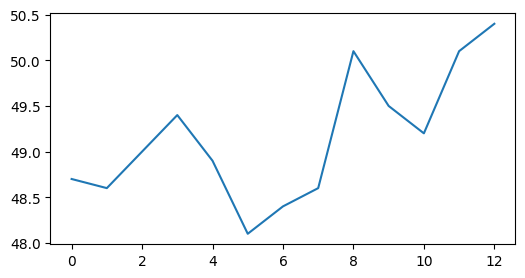

In [76]:
party_data = blue_block.vote_history()
votes = party_data.get("votes").to_list() # type: ignore
display(party_data)
plt.figure(figsize=[6, 3])
plt.plot(range(len(votes)), votes)
plt.show()

In [77]:
party_data

,votes
0,48.7
1,48.6
2,49.0
3,49.4
4,48.9
5,48.1
6,48.4
7,48.6
8,50.1
9,49.5


In [78]:
votes_arr = np.array(votes)
mean = votes_arr.mean()
std = votes_arr.std()
votes_norm = (votes_arr - mean) / std

X_train = torch.tensor(votes_norm[:-1]).float()
y_train = torch.tensor(votes_norm[1:]).float()
X_test = torch.tensor(votes_norm[:-1]).float()
y_test = torch.tensor(votes_norm[-1]).float()

print(f"X_train length: {len(X_train)}")
print(f"y_train length: {len(y_train)}")
print(f"X_test length: {X_test.numel()}")
print(f"y_test length: {y_test.numel()}")

X_train length: 12
y_train length: 12
X_test length: 12
y_test length: 1


In [79]:
sequince_length = 3
X, y = create_sequences(X_train.numpy(), seq_length=sequince_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [80]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Hidden state is reset for each epoch
    outputs, _, _ = model(trainX)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/500], Loss: 0.0374
Epoch [100/500], Loss: 0.0001
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0003
Epoch [150/500], Loss: 0.0003
Epoch [200/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0024
Epoch [500/500], Loss: 0.0024


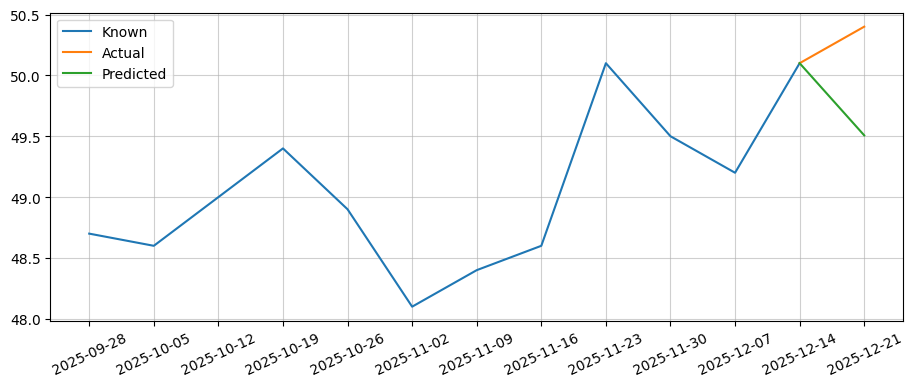

Predicted Vote: 49.51
Actual Vote: 50.40
MAE: 0.893


In [81]:
model.eval()

# Reshape X_test to (Batch Size, Sequence Length, Features)
# Use the last sequince_length elements for prediction
testX = X_test[-sequince_length:].view(1, -1, 1).float()

with torch.no_grad():
    y_pred, _, _ = model(testX)

# Inverse transform
y_pred = y_pred.item() * std + mean
y_test = y_test.item() * std + mean
X_test = X_test.numpy() * std + mean

dates = pd.to_datetime(data["date"].unique())
dates = dates.sort_values()

plt.figure(figsize=[11, 4])
plt.plot(dates[:-1], X_test, label="Known")
plt.plot(dates[-2:], [X_test[-1], y_test], label="Actual")
plt.plot(dates[-2:], [X_test[-1], y_pred], label="Predicted")
plt.xticks(dates, rotation=25)
plt.grid(alpha=0.6)
plt.legend()
plt.show()

print(f"Predicted Vote: {y_pred:.2f}")
print(f"Actual Vote: {y_test:.2f}")
print(f"MAE: {abs(y_pred - y_test):.3f}")

In [82]:
def predict_result(X_test_init, weeks_forward, dates):
    assert(weeks_forward > 0)
    model.eval()

    # Normalize input
    X_test_norm = (X_test_init - mean) / std

    # Reshape X_test_init to (Batch Size, Sequence Length, Features)
    # Use the last sequince_length elements for prediction
    testX = torch.tensor(X_test_norm[-sequince_length:]).view(1, -1, 1).float()
    
    preds = []
    i = 0
    while i < weeks_forward:
        with torch.no_grad():
            y_pred, _, _ = model(testX)
        preds.append(y_pred)
        # Update testX by removing first element and adding new prediction
        testX = torch.cat([testX[:, 1:, :], y_pred.view(1, 1, 1)], dim=1)
        i += 1

    preds_values = [p.item() * std + mean for p in preds]

    # Determine dates corresponding to X_test_init
    known_dates = dates[:len(X_test_init)]
    last_known_date = known_dates[-1]

    # Generate future dates
    future_dates = pd.date_range(start=last_known_date + pd.Timedelta(weeks=1), periods=weeks_forward, freq='W')
    all_dates = known_dates.append(future_dates)

    # Prepare plotting data to connect lines
    plot_future_dates = future_dates.insert(0, last_known_date)
    plot_preds_values = [X_test_init[-1]] + preds_values

    plt.figure(figsize=[11, 4])
    plt.plot(known_dates, X_test_init, label="Known")
    plt.plot(plot_future_dates, plot_preds_values, label="Predicted")
    plt.xticks(all_dates[::2], rotation=25)
    plt.grid(alpha=0.6)
    plt.legend()
    plt.show()

    return preds_values

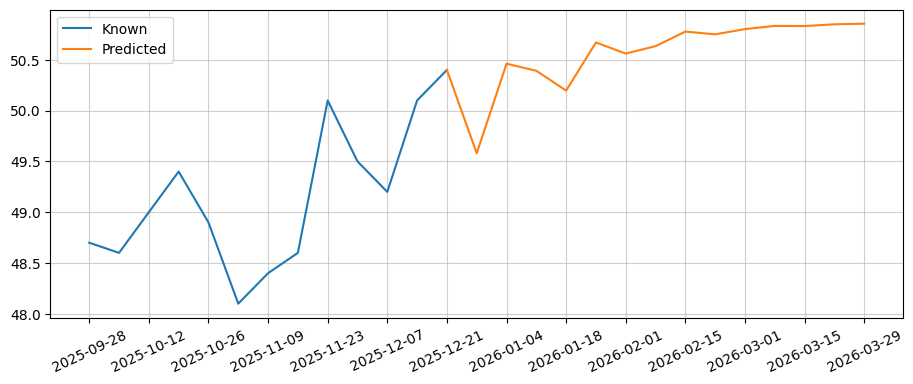

In [83]:
weeks_until_election = round((datetime.strptime("2026-04-04", "%Y-%m-%d")-datetime.strptime(datetime.today().strftime('%Y-%m-%d'), "%Y-%m-%d")).days/7)

dates = pd.to_datetime(data["date"].unique())
dates = dates.sort_values()

preds_values = predict_result(np.append(X_test, y_test), weeks_until_election, dates)